In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
full = train.drop('label', axis=1).append(test)
labels = train['label']

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


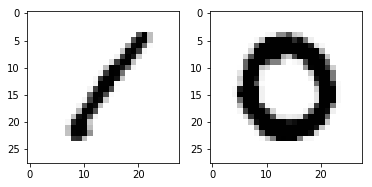

In [2]:
# sanity check
IMAGE_SIZE = 28
NUM_CHECK = 2

def show_first_n_images(data, n):
    reshaped_img = [np.array(data.iloc[i,].reshape((IMAGE_SIZE,IMAGE_SIZE))) for i in range(n)]

    ax_tuple = ('ax' + str(i) for i in xrange(n))
    _, ax_tuple = plt.subplots(1, n)
    for i in xrange(n):
        ax_tuple[i].imshow(reshaped_img[i], cmap=plt.cm.Greys);

show_first_n_images(full, NUM_CHECK)

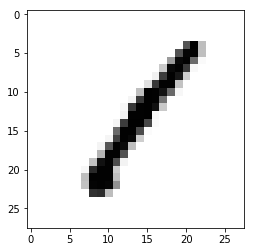

In [3]:
# normalize data

# each pixel is encoded as an integer between 0 and 255
# convert to floats and rescale them to be centered around
# 0, from [-0.5, 0.5]
PIXEL_DEPTH = 255

def normalize_data(data):
    '''Returns a normalized 4d numpy tensor from a pandas data frame
    [image index, y, x, channels]
    '''
    scaled = data.astype(np.float32)
    scaled = (scaled - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH

    # reshape to a set of n images, each IMAGE_SIZE*IMAGE_SIZE rather than
    # each image being represented by a vector of size IMAGE_SIZE^2
    reshaped = scaled.values.reshape(70000, IMAGE_SIZE, IMAGE_SIZE, 1).astype(np.float32)
    return reshaped

full = normalize_data(full)
train_data = full[:42000,]
labels = np.array(labels)
test_data = full[42000:,]

# replot to make sure data isn't mangled
plt.imshow(full[0].reshape(28,28), cmap=plt.cm.Greys);

In [4]:
# Convert labels to dense 1-hot representation of 10 digits
# e.g. 5 is represented by the vector [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

NUM_LABELS = 10 # one for each digit 0..9
train_labels = (np.arange(NUM_LABELS) == labels[:, None]).astype(np.float32)

print('Training labels shape', train_labels.shape)
print('First label vector', train_labels[0])
print('Second label vector', train_labels[1])

('Training labels shape', (42000, 10))
('First label vector', array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))
('Second label vector', array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))


In [5]:
# Create a validation set from training data to help with our model

VALIDATION_SIZE = 5000

validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]

train_size = train_labels.shape[0]

print('Validation shape', validation_data.shape)
print('Train size', train_size)

('Validation shape', (5000, 28, 28, 1))
('Train size', 37000)


In [6]:
# Define our tensorflow variables that will hold weights

import tensorflow as tf

BATCH_SIZE = 42
NUM_CHANNELS = 1
SEED = 42

train_data_node = tf.placeholder(
    tf.float32,
    shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, NUM_LABELS))

validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

conv1_weights = tf.Variable(
    tf.truncated_normal([5, 5, NUM_CHANNELS, 32], # 5x5 filter, depth 32
                        stddev=0.1,
                        seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))

conv2_weights = tf.Variable(
    tf.truncated_normal([5, 5, 32, 64],
                        stddev=0.1,
                        seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))

fc1_weights = tf.Variable(
    tf.truncated_normal([IMAGE_SIZE / 4 * IMAGE_SIZE / 4 * 64, 512],
                        stddev=0.1,
                        seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))

fc2_weights = tf.Variable(
    tf.truncated_normal([512, NUM_LABELS],
                        stddev=0.1,
                        seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

print('Done')

Done


In [7]:
# Define our basic model graph structure

def model(data, train=False):
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    
    # bias and rectified linear non-linearity
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    
    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1,2,2,1],
                          strides=[1,2,2,1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1,2,2,1],
                          strides=[1,2,2,1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
  
    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    if train:
        hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Done')

Done


In [8]:
# Create several copies of the model graph for training, 
# testing, and validation

logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits, train_labels_node))

# L2 regularization for the fully connected parameters
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))

loss += 5e-4 * regularizers

# Set up a variable that is incremented once per batch and
# controls the learning rate decay
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01
learning_rate = tf.train.exponential_decay(
    0.01,                  # Base learning rate
    batch * BATCH_SIZE,    # Current index into the dataset
    train_size,            # Decay step
    0.95,                  # Decay rate
    staircase=True)

optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

train_prediction = tf.nn.softmax(logits)

validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Done')

Done


In [9]:
# Create a new interactive session
s = tf.InteractiveSession()
s.as_default()

# Initialize all the variables
tf.initialize_all_variables().run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
def error_rate(predictions, labels):
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))
    
    confusions = np.zeros([10,10], np.float32)
    bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
        
    return error, confusions

print('Done')

Done


In [ ]:
# Training steps

steps = int(train_size / BATCH_SIZE)
for step in xrange(steps):
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    
    _, l, lr, predictions = s.run(
        [optimizer, loss, learning_rate, train_prediction],
        feed_dict=feed_dict)
    
    if step % (BATCH_SIZE *2):
        error, _ = error_rate(predictions, batch_labels)
        print('Step %d of %d' % (step, steps))
        print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
        print('Validation error: %.1f%%' % error_rate(
            validation_prediction.eval(), validation_labels)[0])

In [ ]:
predictions = test_prediction.eval()
predictions

In [ ]:
# write output to csv
pred_labels = np.argmax(predictions, axis=1)
submission = pd.DataFrame({
        'ImageId': np.arange(1, len(pred_labels) + 1),
        'Label': pred_labels
    })

submission.to_csv('output.csv', index=False)